# 9. Unsupervised Learning Techniques

**Unsupervised Learning Tasks**
- *Clustering:* Grouping similar instances together into clusters
    - Useful for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction
- *Anomaly detection:* learn what 'normal' data looks like and use that to detect abnormal instances
    - Examples could be defective items on a production line or a new trend in a time series
- *Density estimation:* estimating the probability density function of the random process that generated the dataset
    - Used for anomaly detection - instances in low-density regions likely to be anomalies
    - Also useful for data analysis and visualisation

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams.update({"figure.figsize": [10, 8], "font.size": 15})

RANDOM_STATE = 42

## Clustering

**Clustering:** Identifying similar instances and assigning them to clusters
- Similar to classification in that each instance gets assigned to a group
- Some algorithms look for instances centred around a particular point (centroid)
- Some look for continuous regions of densely pakced instances

**Applications**
- *Customer segmentation:* clustering customers based on their purchases and activity
    - Useful in recommender systems - suggest content that users in the same cluster enjoyed
- *Data analysis:* cluster a new dataset and then analyse each cluster separately
- *Dimensionality reduction*
    - Measure each instance's *affinity* with each cluster (how well it fits into the cluster)
    - Feature can be replace with vector of cluster affinities - reducing dimensions
- *Anomaly detection:* an instance with low affinity to all clusters is likely to be an anomaly
    - Particularly useful for detectinng defects in manufacturing or fraud detection
- *Semi-supervised learning:* perform clustering and propogate labels to instances in the same cluster
    - Can greatly increase the umber of labels for subsequet supervised learning
- *Search engines:* searching for images that are similar to a reference image
    - Simply cluster a database of images, assign the reference image to a cluster, and show those images in that cluster
- *Image segmentation:* clustering pixels according to their colour and replacing each pixel's colour with the mean colour of the cluster
    - Reduces number of cvolours - useful for detection and tracking as it's easier to detect contours of objects

### K-means

- Generates $k$ centroids and assigns instances to the cluster with the closest centroid
- Need to specify $k$
- Simple and can cluster quickly and efficiently in few iterations
- Doesn't behave well when the blobs have very different diameters because it only looks at distance to centroid
- *Hard clustering:* assigning each instance to a cluster
- *Soft clustering:* assign an instance a score per cluster e.g. distance or a similarity/affinity score such as using GRBFs
- Soft clustering assigns to each instance a $k$-dimensional vector, this is an efficient for non-linear dimensionality reduction 

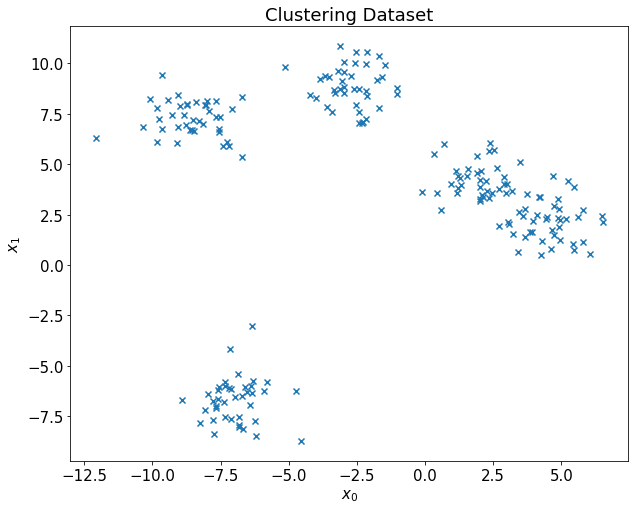

In [2]:
# generate sample data
from sklearn.datasets import make_blobs

X, _, centers = make_blobs(
    n_samples=200,
    n_features=2,
    centers=5,
    cluster_std=1,
    shuffle=True,
    random_state=RANDOM_STATE,
    return_centers=True,
)


def plot_dataset(X, y=None, ax=None, rgba_mapper=None):
    "rgba should be a function that takes values in y and outputs colors in rbga format"
    if not ax:
        fig, ax = plt.subplots()

    if not isinstance(y, np.ndarray):
        ax.scatter(X[:, 0], X[:, 1], marker="x")
    else:
        # default colors if nothing specified
        prop_cycle = plt.rcParams["axes.prop_cycle"]
        colors = prop_cycle.by_key()["color"]

        for i, cluster in enumerate(np.unique(y)):
            if rgba_mapper:
                color = rgba_mapper(cluster)
            else:
                color = colors[i]

            ax.scatter(X[y == cluster, 0], X[y == cluster, 1], marker="x", color=color)

    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")

    ax.set_title("Clustering Dataset")


plot_dataset(X)

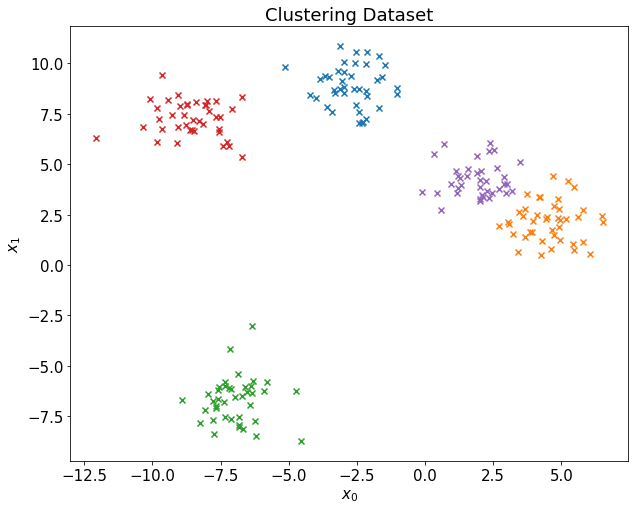

In [3]:
# clustering with kmeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
y_pred = kmeans.fit_predict(X)

plot_dataset(X, y_pred)

In [4]:
# compare detected centres with actual centres
print("Original centres:")
for i in range(centers.shape[0]):
    print("({:.1f}, {:.1f})".format(centers[i, 0], centers[i, 1]))

Original centres:
(-2.5, 9.0)
(4.6, 2.0)
(-6.9, -6.9)
(-8.8, 7.3)
(2.0, 4.2)


In [5]:
# compare detected centres with actual centres
print("K-means centres:")
for i in range(kmeans.cluster_centers_.shape[0]):
    print(
        "({:.1f}, {:.1f})".format(
            kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1]
        )
    )

K-means centres:
(-2.7, 8.9)
(4.5, 2.2)
(-7.0, -6.7)
(-8.6, 7.3)
(1.9, 4.2)


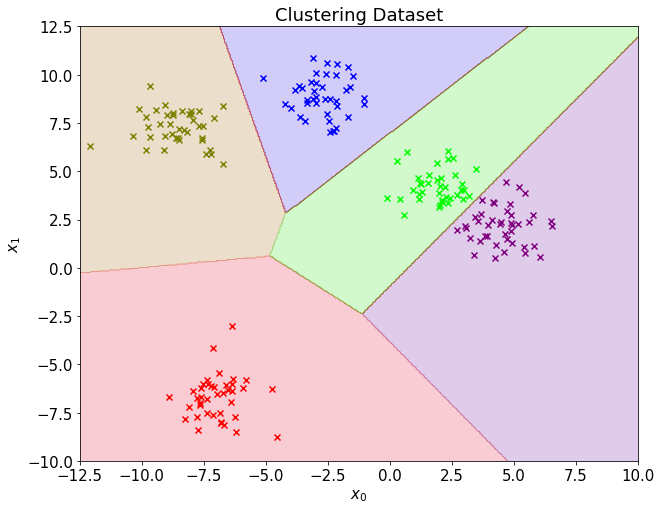

In [6]:
# plot decision boundaries
def plot_decision_boundaries(xlim, ylim, ax=None):
    if not ax:
        fig, ax = plt.subplots()

    x0s = np.linspace(xlim[0], xlim[1], 500)
    x1s = np.linspace(ylim[0], ylim[1], 500)

    # each is a 500 x 500 array with all values of xlim/ylim repeated
    x0, x1 = np.meshgrid(x0s, x1s)

    # put in array of pairs (x0, x1) for predictions
    X = np.c_[x0.ravel(), x1.ravel()]

    y_pred = kmeans.predict(X).reshape(x0.shape)

    contours = ax.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

    return contours


xlim = (-12.5, 10)
ylim = (-10, 12.5)

fig, ax = plt.subplots()

contours = plot_decision_boundaries(xlim, ylim, ax=ax)
plot_dataset(X, y_pred, ax=ax, rgba_mapper=contours.to_rgba)

In [7]:
# transform method gives istance to centers
X_test = np.array([[-3, 0]])
kmeans.transform(X_test)

array([[8.88810233, 7.85381196, 7.7854957 , 9.15108442, 6.46461448]])

In [8]:
# define an affinity function using Gaussian RBFs
from sklearn.gaussian_process.kernels import RBF

rbf = RBF(3)  # scale parameter
rbf_affinity = lambda x: rbf.__call__(kmeans.cluster_centers_, x)
rbf_affinity(X_test)

array([[0.01241564],
       [0.03249081],
       [0.03447774],
       [0.00953913],
       [0.09810317]])

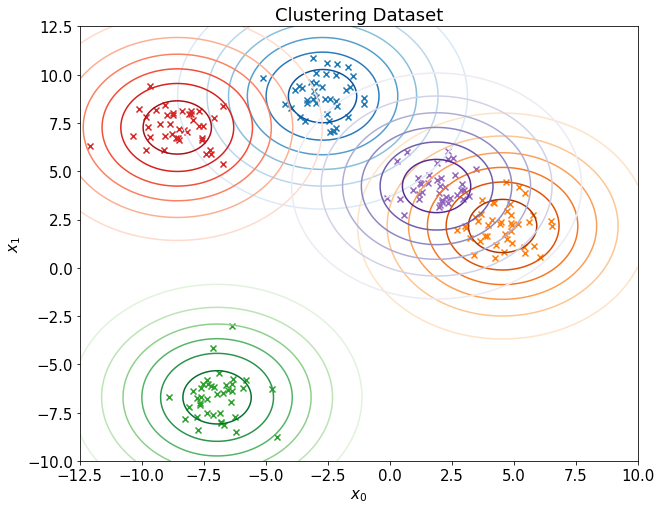

In [9]:
# plot contours for affinity
def plot_affinity(xlim, ylim, ax=None):
    if not ax:
        fig, ax = plt.subplots()

    x0s = np.linspace(xlim[0], xlim[1], 500)
    x1s = np.linspace(ylim[0], ylim[1], 500)

    # each is a 500 x 500 array with all values of xlim/ylim repeated
    x0, x1 = np.meshgrid(x0s, x1s)

    # put in array of pairs (x0, x1) for predictions
    X = np.c_[x0.ravel(), x1.ravel()]

    # y_pred = kmeans.transform(X)
    aff = rbf_affinity(X)

    cmaps = ["Blues", "Oranges", "Greens", "Reds", "Purples"]
    for cluster in range(aff.shape[0]):
        cmap = cmaps[cluster]
        ax.contour(x0, x1, aff[cluster, :].reshape(x0.shape), cmap=cmap)


xlim = (-12.5, 10)
ylim = (-10, 12.5)

fig, ax = plt.subplots()

contours = plot_affinity(xlim, ylim, ax=ax)
plot_dataset(X, y_pred, ax=ax)

**The K-Means Algorithm:**
- Algorithm:
    0. Pick $k$ centoids randomly
    1. Assign all training instances to clusters based on the closest centroid
    2. Find the centroid of each cluster - the mean of coordinates in the cluster
    3. Go back to step 1
- *Computational complexity*
    - This is guaranteed to converge in a finite number of steps - inertia can only decrease at each step
    - If the data has 'a clustering structure' the algorithm is $O(m)$, $O(n)$, and $O(k)$
    - If it doesn't the complexity can be $O(e^m)$, but this never happens in practice
- The algorithm is not guaranteed to converge to the global minimum - there are local minima

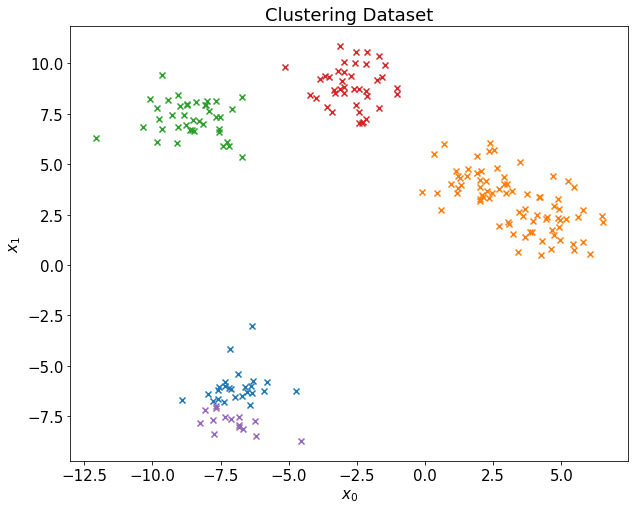

In [10]:
# suboptimal clustering of data
kmeans_sub = KMeans(n_clusters=5, init="random", n_init=1, random_state=RANDOM_STATE)
y_pred = kmeans_sub.fit_predict(X)

plot_dataset(X, y_pred)

**Centroid Initialisation Methods**
- If you know approximately where the centroids are, you can use this as an initialisation
- Alternatively, run the algorithm multiple times with different initialisation and keep the best solution
- Performance metric for fit is *inertia* - mean squared distances of training instances to centroids
- *K-Means++* adds an initilisation step that selects centroids that are far apart and less likely to converge to a suboptimal solution
    1. Randomly select first centroid $\mathbf{c}^{(1)}$ from training instances
    2. Choose new centroid $\mathbf{c}^{(i)}$ from training instances, where instance $i$ has probability $D\left(\mathbf{x}^{(i)}\right)^2 \big/ \sum_{j=1}^m D\left(\mathbf{x}^{(j)}\right)^2$ of being chosen, with $D\left(\mathbf{x}\right)^2$ the distance between $\mathbf{x}$ and the closest existing centroid. Instances far from existing centroids are much more likely to be chosen
    3. Repeat step 2 until all $k$ centroids chosen

In [11]:
# initialise with known centres
kmeans_best = KMeans(n_clusters=5, init=centers, n_init=1)
kmeans_best.fit(X)

print("Known initilisation inertia: {:.1f}".format(kmeans_best.inertia_))
print("One random initilisation inertia: {:.1f}".format(kmeans_sub.inertia_))
print("10 initilisations inertia: {:.1f}".format(kmeans.inertia_))

Known initilisation inertia: 350.6
One random initilisation inertia: 548.2
10 initilisations inertia: 350.6


**Accelerated K-Means and Mini-Batch K-Means**
- *Accelerated K-Means:* exploits the traingle inequality to reduce the number of distance calculations needed and speed up the algorithm
    - `KMeans` uses this by default
- *Mini-Batch K-Means:* uses mini-batches at each iteration rather than the whole dataset
    - Speeds up algorithm by factor of 3-4, but solutions have slightly worse interia - becomes more significant as $k$ increases
    - Allows you to cluster huge datasets that don't fit in memory (either using `memmap` or creating mini-batches and using `partial_fit()`)

In [12]:
from sklearn.cluster import MiniBatchKMeans

mb_kmeans = MiniBatchKMeans(n_clusters=5)
mb_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)

**Finding the Optimal Number of Clusters**
- Higher $k$ will always mean lower inertia (you could always have an empty cluster)
- One way to select $k$ is to plot inertia against $k$ and look for the 'elbow' where adding additional clusters doesn't make much difference to inertia
- A more precise way is to plot *silhouette score* (mean *silhouette coefficient* over training instances) against $k$
- The silhouette coefficient for an instance is $(b-a)/\max(a, b)\in[-1,1]$, where $a$ is the mean distance to the training instances in the cluster and $b$ is the smallest value of this over other clusters
    - This is close to 1 if the instance is much closer to its own cluster instances than others
    - Close to 0 if it is near the boundary of its cluster
    - Close to -1 if it has been assigned to the wrong cluster
- Even more information is a silhouette diagram which plots the silhouette coefficient for each training instance, grouped by cluster, with the silhouette score
- Comparing silhouette diagrams helps compare - you may want to avoid over/undersized clusters and underperforming clusters
- Can plot silhouette diagrams using `Yellowbrick` - a machine learning visualisation package

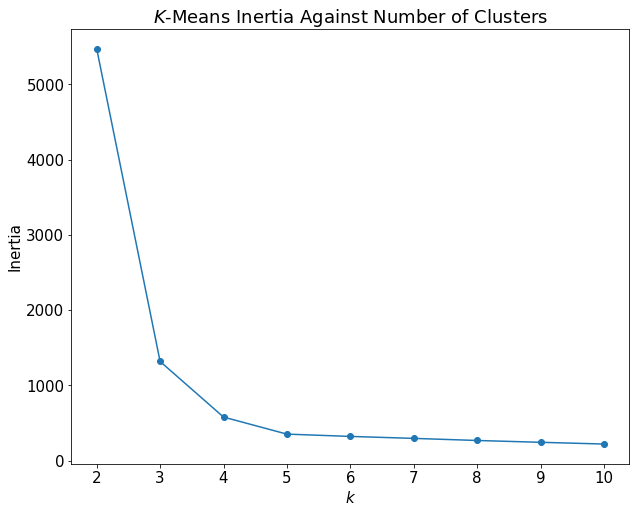

In [13]:
# fit kmeans for different values of k
kmeans_list = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
    kmeans.fit(X)
    kmeans_list.append(kmeans)


def plot_interia_against_clusters(kmeans_list):
    fig, ax = plt.subplots()

    n_clusters = [kmeans.n_clusters for kmeans in kmeans_list]
    inertia = [kmeans.inertia_ for kmeans in kmeans_list]

    ax.plot(n_clusters, inertia, marker="o")

    ax.set_xlabel("$k$")
    ax.set_ylabel("Inertia")

    ax.set_title("$K$-Means Inertia Against Number of Clusters")


plot_interia_against_clusters(kmeans_list)

Looks like 4 or 5 clusters would be optimal

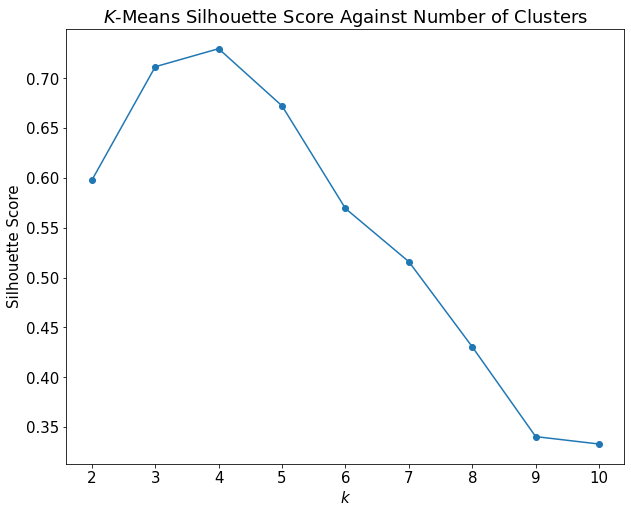

In [14]:
from sklearn.metrics import silhouette_score


def plot_silhouette_scores(kmeans_list, X):
    fig, ax = plt.subplots()

    n_clusters = [kmeans.n_clusters for kmeans in kmeans_list]
    silhouette = [silhouette_score(X, kmeans.labels_) for kmeans in kmeans_list]

    ax.plot(n_clusters, silhouette, marker="o")

    ax.set_xlabel("$k$")
    ax.set_ylabel("Silhouette Score")

    ax.set_title("$K$-Means Silhouette Score Against Number of Clusters")


plot_silhouette_scores(kmeans_list, X)

Shows that $k=3, 4, 5$ are much better than other options

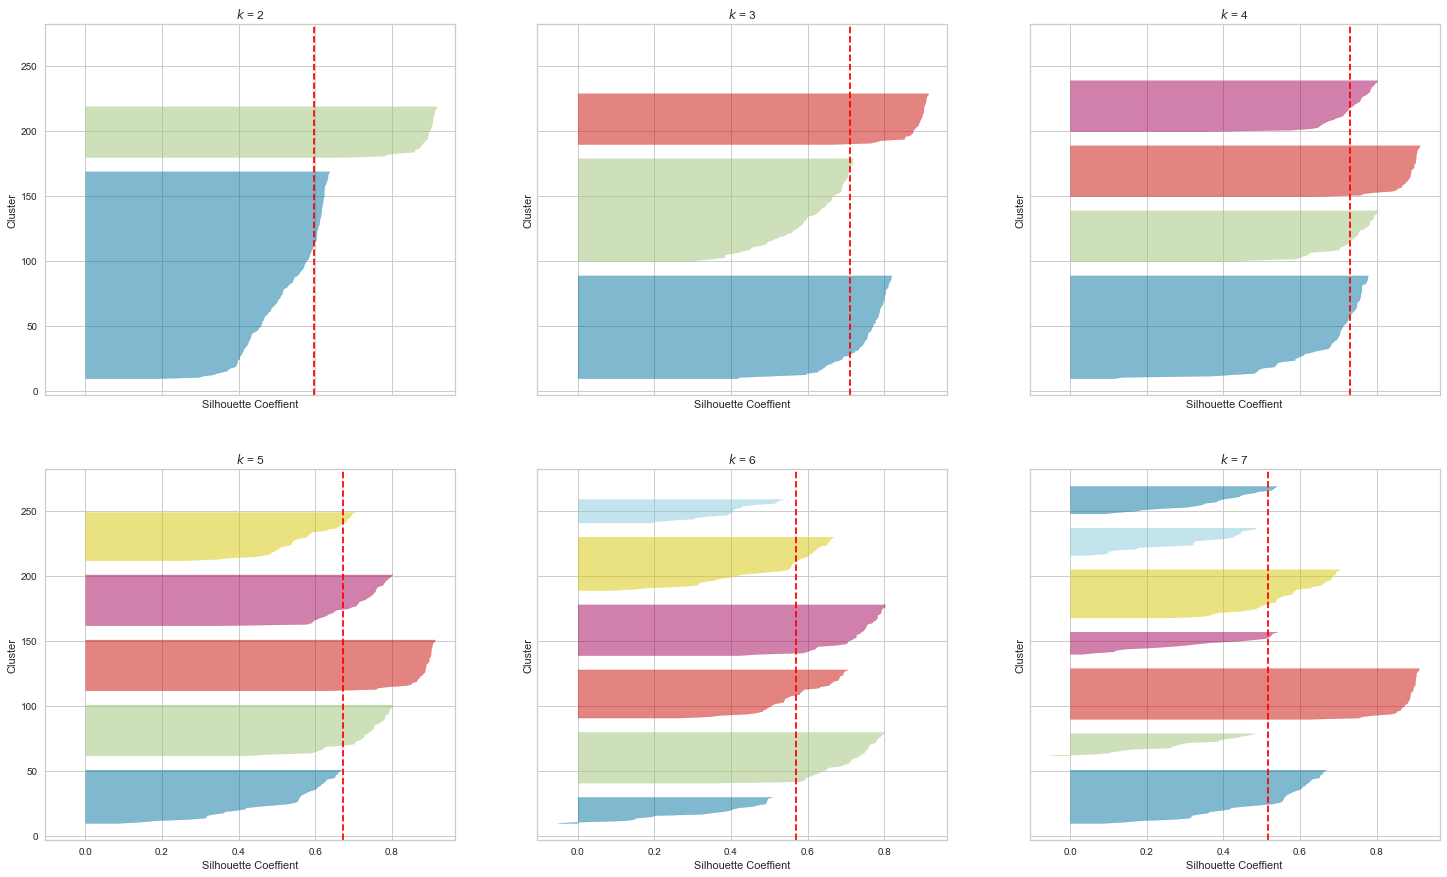

In [15]:
from yellowbrick.cluster import SilhouetteVisualizer


fig, axs = plt.subplots(2, 3, figsize=(25, 15), sharex=True, sharey=True)
axs_ravel = axs.ravel()

for i, kmeans in enumerate(kmeans_list[:6]):
    ax = axs_ravel[i]
    visualizer = SilhouetteVisualizer(kmeans, ax=ax, colors='yellowbrick')
    visualizer.fit(X)
     
    ax.set_title("$k$ = {}".format(kmeans.n_clusters))

    ax.set_xlabel("Silhouette Coeffient")
    ax.set_ylabel("Cluster")

Clearly $k=2, 6, 7$ do not perform well. $k=3$ does look pretty good. $k=4$ does have the advantage that clusters are approximately the same size.

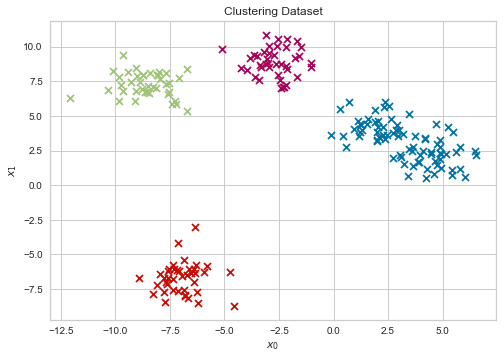

In [18]:
# clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE)
y_pred = kmeans.fit_predict(X)

plot_dataset(X, y_pred)